In [2]:
import pandas as pd
df = pd.read_csv('../data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [3]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
print(df['TotalCharges'].isnull().sum())
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

11


In [4]:
df = df.drop(columns=['customerID'])

In [5]:
df['Churn'] = df['Churn'].map({'Yes':1,'No':0})

In [6]:
from sklearn.preprocessing import LabelEncoder
cat_cols = df.select_dtypes(include='object').columns
le = LabelEncoder()
for c in cat_cols:
    df[c] = le.fit_transform(df[c].astype(str))

In [7]:
df = pd.get_dummies(df, drop_first=True)

In [8]:
from sklearn.preprocessing import StandardScaler
num_cols = ['tenure','MonthlyCharges','TotalCharges']
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [9]:
import pickle
with open('../models/scaler.pkl','wb') as f:
    pickle.dump(scaler,f)

In [10]:
import pickle

# After df is fully preprocessed and before splitting out X, y:
feature_names = df.drop('Churn', axis=1).columns.tolist()
with open('../models/feature_names.pkl', 'wb') as f:
    pickle.dump(feature_names, f)


In [11]:
from sklearn.model_selection import train_test_split
X = df.drop('Churn',axis=1)
y = df['Churn']
X_train,X_test,y_train,y_test = train_test_split(
    X,y,test_size=0.2,stratify=y,random_state=42)

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train,y_train)
print('LR AUC:',roc_auc_score(y_test,lr.predict_proba(X_test)[:,1]))

LR AUC: 0.8402903717481722


In [13]:
from xgboost import XGBClassifier
xgb = XGBClassifier(objective='binary:logistic',eval_metric='logloss',n_estimators=100)
xgb.fit(X_train,y_train)
print('XGB AUC:',roc_auc_score(y_test,xgb.predict_proba(X_test)[:,1]))

XGB AUC: 0.8185396161099487


In [14]:
with open('../models/xgb.pkl','wb') as f:
    pickle.dump(xgb,f)

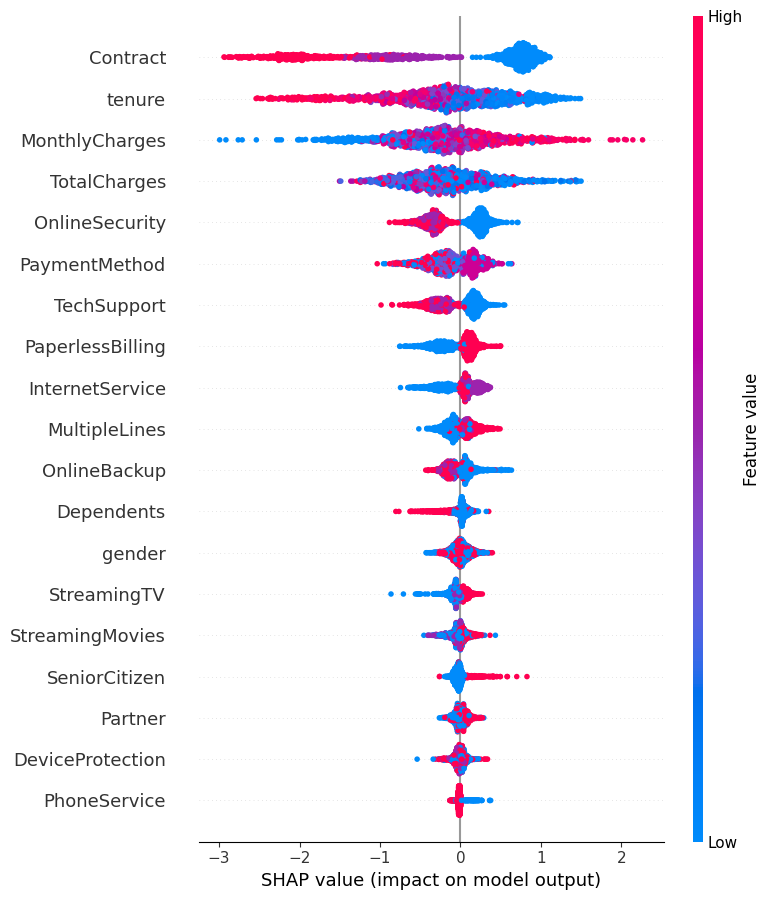

In [15]:
import shap
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values,X_test)